# Проект "Выбор локации для скважины"


Данные:
 - предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.
 - находятся в 3-х файлах(geo_data_0.csv,geo_data_1.csv,geo_data_2.csv), в которых:
  - id — уникальный идентификатор скважины;
  - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
  - product — объём запасов в скважине (тыс. баррелей).

Задача:
 - необходимо определить регион, в котором добыча принесет наибольшую прибыль, с помощью модели машинного обучения. Анализ  возможной прибыли и рисков необходимо провести техникой *Bootstrap.*

Условия задачи:
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


## Загрузка и подготовка данных

Загрузим и подготовим данные:
- загрузим данные и проведем визуальную оценку,
- проанализируем общую информацию для понимания корректности типов данных и наличия/отсутствия пропусков,
- проанализируем на наличие/отсутствие явных/неявных дубликатов, очистим от них данные,
- проведем сравнительный анализ признаков по регионам,
- проведем корреляционный анализ признаков по регионам.

### Загрузка данных

In [1]:
#импортируем необходимые библиотеки,
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
from scipy import stats as st
from sklearn.model_selection import train_test_split

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error,r2_score

# загружаем нужные модели
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#загрузим данные из файла games.csv
def download(file):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'

    if os.path.exists(path_1):
        data = pd.read_csv(path_1, sep=',')
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2, sep=',')
    else:
        print('Something is wrong')
        
    return data 

In [3]:
#загрузим данные из файла для первого региона
data_1 = download('geo_data_0')

#выведем первые 5 строк
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [4]:
#загрузим данные из файла для второго региона
data_2 = download('geo_data_1')

#выведем первые 5 строк
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [5]:
#загрузим данные из файла для третьего региона
data_3 = download('geo_data_2')

#выведем первые 5 строк
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


На первый взгляд с данными все в порядке. Проведем первичный анализ данных

### Общая информация о данных

In [6]:
#запишем в словарь название региона и датафрейм соответствующего региона
frames = {
    'Первый регион':data_1,
    'Второй регион':data_2,
    'Третий регион':data_3
}
#в цикле выведем инфо по регионам
for name, df in frames.items():
    print(name)
    df.info()
    print('\n\n')   

Первый регион
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



Второй регион
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



Третий регион
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data co

Пропуски в данных отсутствуют, типы данных корректные: тип  id - строковой, признаков и объема запасов - числовой.В таблице по каждому региону присутствует по 100 000 строк.

Далее проверим на явные и неявные дубликаты

### Проверка на дубликаты

In [7]:
#в цикле выведем инфо по регионам
for name, df in frames.items():
    print(f'Кол-во полных дубликатов для {name}:{df.duplicated().sum()}')

Кол-во полных дубликатов для Первый регион:0
Кол-во полных дубликатов для Второй регион:0
Кол-во полных дубликатов для Третий регион:0


In [8]:
#выведем дубликаты скважин для каждого региона
for name, df in frames.items():
    print(f'Кол-во дубликатов по id скважин для {name}:{df["id"].duplicated().sum()}')

Кол-во дубликатов по id скважин для Первый регион:10
Кол-во дубликатов по id скважин для Второй регион:4
Кол-во дубликатов по id скважин для Третий регион:4


Явные (полные) дубликаты отсутствуют.
Необходимо понять чем отличаются строки с однаковыми названиями скважин. Для примера введем дубликаты скважин для 2-го региона и посмотрим на примере 2-х дубликатов

In [9]:
data_2.loc[data_2['id'].duplicated()].head(2)

,id,f0,f1,f2,product
41906,LHZR0,-8.99,-4.29,2.01,57.09
82178,bfPNe,-6.20,-4.82,3.00,84.04


In [10]:
print(data_2.loc[data_2['id']=='LHZR0'],'\n\n',data_2.loc[data_2['id']=='bfPNe'])

          id    f0    f1   f2  product
1305   LHZR0 11.17 -1.95 3.00    80.86
41906  LHZR0 -8.99 -4.29 2.01    57.09 

           id    f0    f1   f2  product
2721   bfPNe -9.49 -5.46 4.01   110.99
82178  bfPNe -6.20 -4.82 3.00    84.04


Явные (полные) дубликаты отсутствуют, при этом есть дубликаты месторождений в каждом регионе с видимо разными значениями признаков f0, f1, f2. Возможно при сборе данных разным месторождениям присвоили одно и то же значение id -  удалим эти дубликаты месторождений.

In [11]:
data_1 = data_1.loc[~data_1['id'].duplicated()].reset_index(drop=True)
data_2 = data_2.loc[~data_2['id'].duplicated()].reset_index(drop=True)
data_3 = data_3.loc[~data_3['id'].duplicated()].reset_index(drop=True)

### Сравнительный анализ признаков по регионам

In [12]:
#выведем статистику датафреймов по регионам в цикле
for name, df in frames.items():
    print(name)
    print(df.describe().T)
    print('\n\n')    

Первый регион
             count  mean   std    min   25%   50%    75%    max
f0      100,000.00  0.50  0.87  -1.41 -0.07  0.50   1.07   2.36
f1      100,000.00  0.25  0.50  -0.85 -0.20  0.25   0.70   1.34
f2      100,000.00  2.50  3.25 -12.09  0.29  2.52   4.72  16.00
product 100,000.00 92.50 44.29   0.00 56.50 91.85 128.56 185.36



Второй регион
             count  mean   std    min   25%   50%    75%    max
f0      100,000.00  1.14  8.97 -31.61 -6.30  1.15   8.62  29.42
f1      100,000.00 -4.80  5.12 -26.36 -8.27 -4.81  -1.33  18.73
f2      100,000.00  2.49  1.70  -0.02  1.00  2.01   4.00   5.02
product 100,000.00 68.83 45.94   0.00 26.95 57.09 107.81 137.95



Третий регион
             count  mean   std    min   25%   50%    75%    max
f0      100,000.00  0.00  1.73  -8.76 -1.16  0.01   1.16   7.24
f1      100,000.00 -0.00  1.73  -7.08 -1.17 -0.01   1.16   7.84
f2      100,000.00  2.50  3.47 -11.97  0.13  2.48   4.86  16.74
product 100,000.00 95.00 44.75   0.00 59.45 94.93 130.60

 - Первый регион:
   - Кол-во строк стало на 10 дуликатов меньше, значения признаков f0, f1, f2 имеют как отрицательные, так и положительные значения, объем запасов в месторождениях от 0 до 185 тыс баррелей.
 - Второй регион:
   - Кол-во строк стало на 4 дуликата меньше, значения признаков f0, f1, f2 имеют как отрицательные, так и положительные значения, объем запасов в месторождениях от 0 до 138 тыс баррелей.
 - Третий регион:
   - Кол-во строк стало на 4 дуликата меньше, значения признаков f0, f1, f2 имеют как отрицательные, так и положительные значения, объем запасов в месторождениях от 0 до 190 тыс баррелей.
   
По совокупности статистики данных по 3-м регионам можно сказать, что значения мин/макс значения признаков f0, f1, f2 для регионов сильно разнятся, при этом объем запасов в скважине не превышет 190 тыс баррелей.

Сравним значения признаков по регионам визуально путем анализа распределения и размаха значений признаков.  

In [13]:
#создадим таблицу с объединением данных по регионам в один, предварительно пометив к какому региону относится,
#после объединения из исходных таблиц удалим признак региона
data_1['number'] = 1
data_2['number'] = 2
data_3['number'] = 3
data_all = pd.concat([data_1, data_2, data_3])
data_1 = data_1.drop(['number'],axis=1)
data_2 = data_2.drop(['number'],axis=1)
data_3 = data_3.drop(['number'],axis=1)

In [14]:
#напишем функцию для вывода гистограммы и боксплота по каждому признаку в разрезе регионов
def hist_box(data,column):
    fig, ax = plt.subplots(figsize = (20, 5));
    
    ax = plt.subplot(1, 2, 1)
    data.query('number==1').plot(kind='hist',y=column,histtype='step',bins=50,\
                                 linewidth=5,alpha=0.7,label='Первый регион',ax=ax);
    data.query('number==2').plot(kind='hist',y=column,histtype='step',bins=50,\
                                 linewidth=5,alpha=0.7,label='Второй регион',ax=ax);
    data.query('number==3').plot(kind='hist',y=column,histtype='step',bins=50,\
                                 linewidth=5,alpha=0.7,label='Третий регион',ax=ax);
    plt.ylabel('Кол-во скважин', fontsize=12);
    plt.xlabel(column, fontsize=12);
    plt.title('Гистограмма распределения');

    data.boxplot(column,by='number', ax = plt.subplot(1, 2, 2));
    plt.ylabel('Значение по признаку '+column, fontsize=12);
    plt.xlabel('Регион', fontsize=12);
    plt.title('Диаграмма размаха');

    fig.suptitle('Распределение значений  в разрезе регионов по признаку '+column,fontsize=14);
    plt.subplots_adjust(wspace=1,hspace = 1);
    plt.show();

<Figure size 432x288 with 0 Axes>

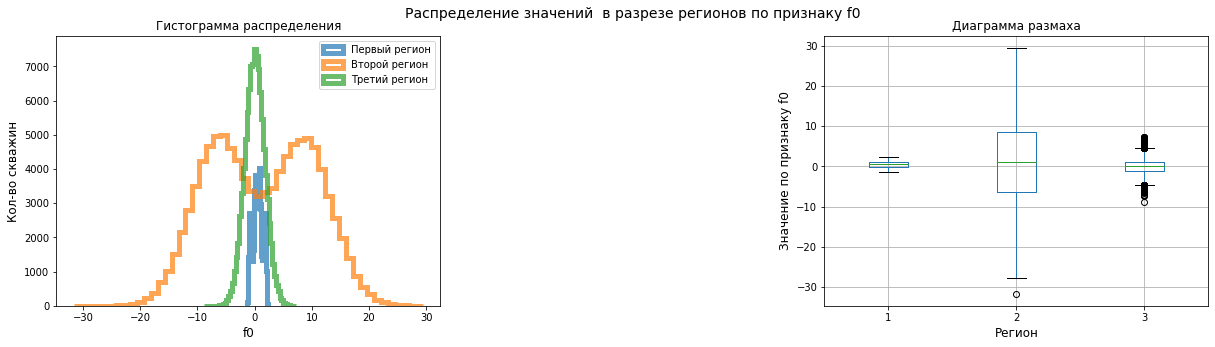

<Figure size 432x288 with 0 Axes>

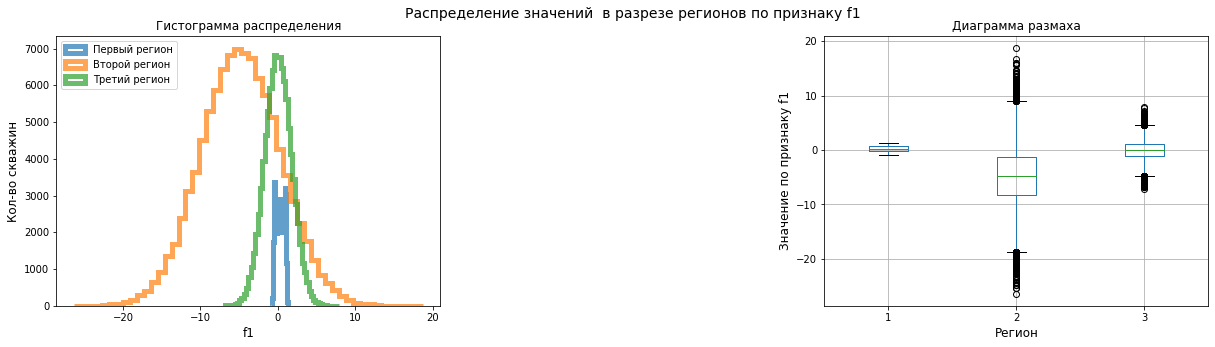

<Figure size 432x288 with 0 Axes>

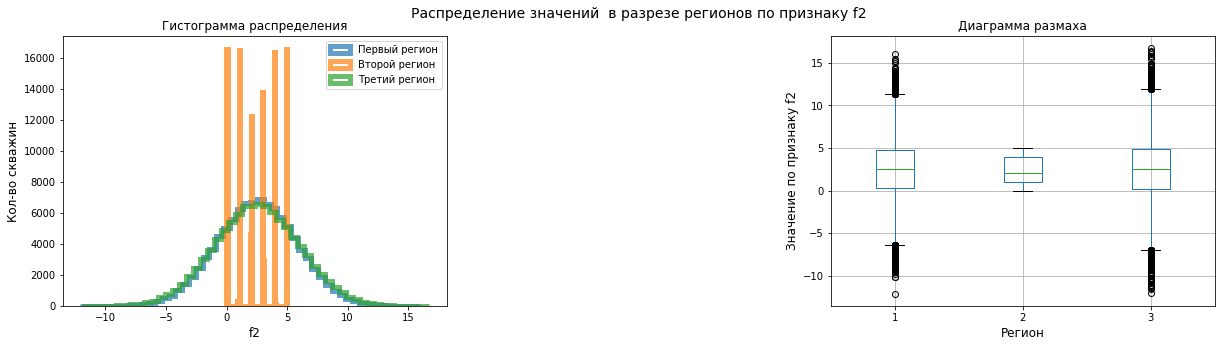

<Figure size 432x288 with 0 Axes>

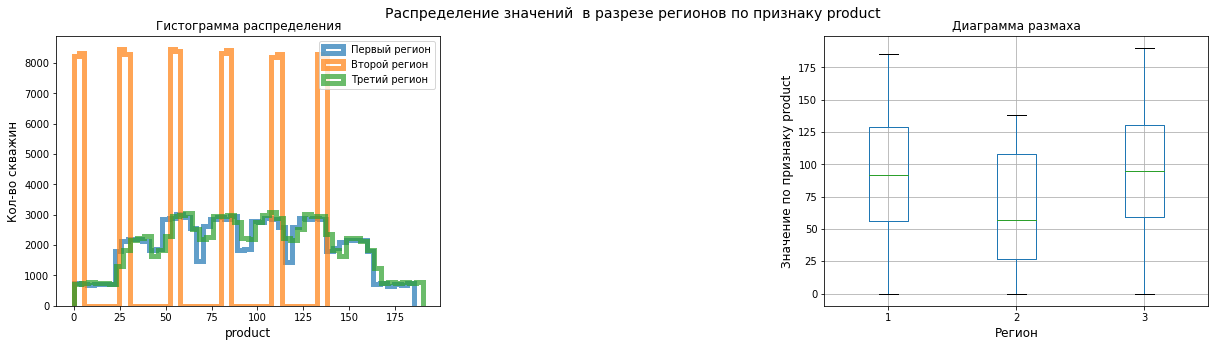

In [15]:
#выведем  диаграммы 
for i in  data_all.drop(['id','number'],axis=1).columns.tolist():
    plt.subplots_adjust(hspace = 1.5);
    hist_box(data_all, i);

 - Как близкое к нормальному оценивается распределение признаков по регионам 1 и 3, по 2-му региону только распределение признака f1 близко к нормальному, 
 - Признак f0: медиана колеблется в одном интервале, при этом размах значений по регионам отличается в разы, для 3-го региона ряд значений оцениваются как выбросы.
 - Признак f1: размах значений аналогично по регионам отличается в разы, но при этом еще и медиана существенно отличается, для 2-го и 3-го региона присутствует большое кол-во выбросов
 - Признак f2: медиана по регионам колеблется в одном интервале, значения между 1-м и 3-м квартилями находятся примерно в одном интервале, но при этом размах значения по 2-му региону в разы меньше, чем для 1-го и 3-го. Для 1-го и 3-го региона часть значений оцениваются как выбросы.
 - Признак product: размах значений, медиана, 1-й и 3-й квартили для 1-го и 3-го месторождения очень приближены, в то время как у 2-го месторождения эти показатели существенно ниже.
 
Проверим корреляцию между признаками для каждого региона 

### Корреляционный анализ

In [16]:
#функция для построения матрицы корреляции
def heatmap(data):
    fig, ax = plt.subplots(figsize=(8, 4));
    sns.heatmap(data.drop(['id'],axis=1).corr(), ax=ax, annot=True, fmt='.2f');

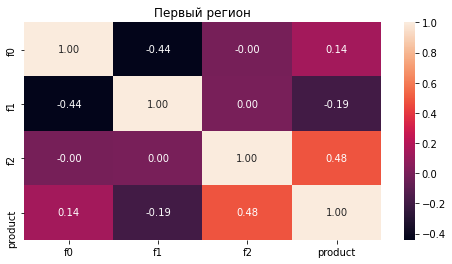

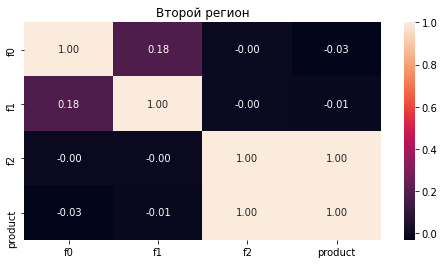

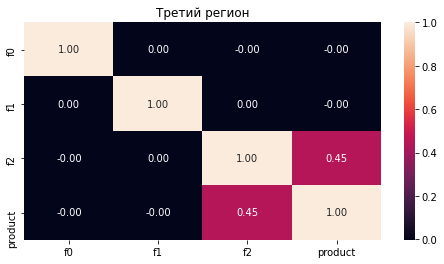

In [17]:
#построим матрицу корреляции
for name,df in frames.items():
    heatmap(df)
    plt.title(name) 

 - Первый регион. Прослеживается прямая коррелиция объемов и признака f2, а также отрицательная корреляция признаков f0 и f1. Корреляция объемов и признаков f0 и f1 прямая слабая и обратная слабая соответственно.
 - Второй регион.Прослеживается максимальная корреляция между признаком f2 и объемами - коэф-и равен 1. Также присутствует слабая прямая корреляция признаков f0 и f1.
 - Третий регион.Корреляция прослеживается только между признаком f2 и объемом запасов - средняя и прямая.

**Вывод по первичному анализу данных**:

 - пропуски в данных отсутствуют,
 - типы данных корректные,
 - полные дубликаты отсутствуют, дубликаты с одинаковым id скважин есть в данных каждого региона - удалены (кол-во таких дубликатов от 4 до 10),
 - размах значений признаков f0, f1 в разы отличается по регионам, по признаку f2 - для региона 1 и 3 размах значений примерно в одном интервале, в то время как для 2-го региона размах по данному признаку существенно меньше(для 2-го региона все значения находятся в интервале от 0 до 5, в то время как для 1-го и 3-го региона в интервале от -12 до 17). Объем запасов: размах значений, медиана, 1-й и 3-й квартили для 1-го и 3-го месторождения очень приближены, в то время как у 2-го месторождения эти показатели существенно ниже. 
 - для разных регионов корреляция признаков и целевого признака (объем запасов) существенно отличается, общим является наличие прямой корреляции признака f2 с целевым, при этом для 2-го региона коэф-т корреляции равен 100%.
 

## Обучение и проверка модели

In [18]:
#проверим на наличие дубликатов после удаления id
print(data_1.drop(['id'],axis=1).duplicated().sum(),data_2.drop(['id'],axis=1).duplicated().sum(),\
      data_3.drop(['id'],axis=1).duplicated().sum())

0 0 0


Обучим и проверим модель для каждого региона.
 - Напишем фукнцию, в которой:
   - Разбиваются данные на обучающую и валидационную выборки в соотношении 75:25.
   - Модель обучается и делает предсказания на валидационной выборке.
 - Сохраним предсказания и правильные ответы на валидационной выборке.
 - Выведем средний запас предсказанного сырья и RMSE модели.
 - Дополнительно посчитаем качество модели( в качестве показателя возьмем r2 - коэффициент детерминации, т.к. он используется для оценки производительности модели машинного обучения на основе регрессии)

In [19]:
#функция для работы модели
def linear_regr(data):
    #входные признаки
    features = data.drop(['id','product'], axis = 1)
    #целевой признак
    target = data['product']
    #разбивка данных на обучающую и валидационную выборки
    features_train,features_valid,target_train,target_valid = train_test_split( 
                                     features,
                                     target,
                                     test_size = 0.25,
                                     random_state = 12345
    )
    #масштабируем признаки (все признаки количественные)
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    #инициируем модель
    model = LinearRegression()
    #обучим модель
    model.fit(features_train,target_train)
    #сделаем предсказания на валидационной выборке
    predictions = model.predict(features_valid)
    #посчитаем RMSE
    RMSE = mean_squared_error(target_valid, predictions) ** 0.5
    #посчитаем средний запас предсказанного сырь
    predictions_mean = predictions.mean()
    #рассчитаем коэф-т детерминации
    r2 = r2_score(target_valid, predictions)
    
    return predictions,target_valid,predictions_mean,RMSE,r2


In [20]:
#сохраним предсказания и правильные ответы на валидационной выборке
predictions_1,target_valid_1,predictions_mean_1,RMSE_1,r2_1 = linear_regr(data_1)
predictions_2,target_valid_2,predictions_mean_2,RMSE_2,r2_2 = linear_regr(data_2)
predictions_3,target_valid_3,predictions_mean_3,RMSE_3,r2_3 = linear_regr(data_3)

In [21]:
#выведем средний предсказанный запас сырья и значение RMSE  по регионам
print('Средний предсказанный запас сырья - Регион первый: ',round(predictions_mean_1,2),', RMSE',round(RMSE_1,2))
print('Средний предсказанный запас сырья - Регион второй: ',round(predictions_mean_2,2),', RMSE',round(RMSE_2,2))
print('Средний предсказанный запас сырья - Регион третий: ',round(predictions_mean_3,2),', RMSE',round(RMSE_3,2))

Средний предсказанный запас сырья - Регион первый:  92.79 , RMSE 37.85
Средний предсказанный запас сырья - Регион второй:  69.18 , RMSE 0.89
Средний предсказанный запас сырья - Регион третий:  94.87 , RMSE 40.08


- В первом регионе: средний предсказанный запас сырья порядка 92.8 тыс баррелей, точность оценки предсказания объемов запасов составляет плюс/минус 37.9 тыс баррелей.
- Во втором регионе: средний предсказанный запас сырья порядка 69.2 тыс баррелей - самое низкое значение по регионам, точность оценки предсказания объемов запасов составляет плюс/минус 0.9 тыс баррелей - самое точное по регионам
- В третьем регионе: средний предсказанный запас сырья порядка 94.9 тыс баррелей, точность оценки предсказания объемов запасов составляет плюс/минус 40.1 тыс баррелей.
Т.о., самое низкое среднее предсказанных запасов скважины у 2-го региона, для 1-го и 3-го аналогичное значение выше более чем на 1/3 и примерно одинаковое между собой. При этом самая высокая точность предсказания у 2-го региона.

Выведем коэф-т детерминации модели для каждого региона

In [22]:
print(f'r2 модели первого региона:{round(r2_1,4)}\n',f'r2 модели второго региона:{round(r2_2,4)}\n',\
      f'r2 модели третьего региона:{round(r2_3,4)}\n')

r2 модели первого региона:0.2724
 r2 модели второго региона:0.9996
 r2 модели третьего региона:0.1956



Метрики r2 для 1-го и 3-го региона низкие, можно  сказать, что модель  прогнозирует лучше, чем условные случайные предсказания.
При этом для 2-го региона видим значение коэф-та почти 1: это обусловлено прямой корреляцией признака f2 с целевым, замеченной нами ранее.

**Вывод по обучению и проверке модели**:

Обучена модель линейной регресии:
- На основании данной модели для каждого региона посчитаны предсказания объемов запасов скважин,определена точность предсказания:самое низкое среднее предсказанных запасов скважины у 2-го региона(69.2 тыс баррелей), для 1-го и 3-го аналогичное значение выше более чем на 1/3 и примерно одинаковое между собой, при этом самая высокая точность предсказания у 2-го региона - предсказанное значение отличается от фактического на плюс/минус 0.9 тыс. баррелей.
- коэф-т детерминации r2 для 1-го и 3-го региона низкие (0.27 и 0.2 соответственно), можно  сказать, что модель  прогнозирует лучше, чем условные случайные предсказания. При этом для 2-го региона видим значение коэф-та почти 1: это обусловлено прямой корреляцией признака f2 с целевым, замеченной нами ранее.

## Подготовка к расчёту прибыли

Запишем в переменные все ключевые значения, посчитаем объем сырья для безубыточной разработки новой скважины

In [23]:
BUDGET = 10_000_000_000 # бюджет на разработку
MAX_POINTS = 500 #при разведке региона исследуют 500 точек
BEST_POINTS = 200 #лучшие точки из исследуемых 500
REVENUE_BARREL = 450000 #доход с каждой единицы продукта
PROBABILITY_LOSS=  2.5 #порог приемлемой вероятности убытков
BREAK_EVEN= BUDGET/REVENUE_BARREL/BEST_POINTS #
print(f'Объем сырья для безубыточной разработки новой скважины - {round(BREAK_EVEN,2)} тыс. баррелей')              

Объем сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей


Среднее предсказанное значение объема сырья скважины для каждого региона (92.8, 62.2, 94.9 тыс) меньше, чем точка безубыточности. Но это средние значения, а согласно проведенного анализа выше для каждого региона присутствуют скважины, значение объема которых превышает необходимое значение безубыточности - посчитаем долю таких точек

In [24]:
#напишем функцию для подсчета доля скважин с запасами не менее 111.11 тыс
def percent(data):
    return len(data.loc[data['product']>=111.11])*100/len(data)
#выведем долю в цикле
for name, df in frames.items():
    print(f'Процент безубыточных точек ({name}): {round(percent(df),2)}%')  

Процент безубыточных точек (Первый регион): 36.58%
Процент безубыточных точек (Второй регион): 16.54%
Процент безубыточных точек (Третий регион): 38.18%


Т.о., несмотря на недостаточное для безубыточности значение средних предсказанных объемов запасов, в каждом регионе все-таки присутствуют необходимые скважины

Напишем функции для расчёта прибыли по скважинам с максимальными значениями предсказаний

In [25]:
#функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def income(target_true, target_pred,count):
    sort_pred = pd.Series(target_pred).sort_values(ascending=False)[:count]
    selected = target_true.reset_index(drop = True)[sort_pred.index]
    return round((selected.sum() * REVENUE_BARREL) - BUDGET,2)

**Вывод по подготовке к расчету прибыли**:

- Объем сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей, что существенно ниже, чем среднее предсказанное значение объема сырья скважины для каждого региона (92.8, 69.2, 94.9 тыс). При этом,  несмотря на недостаточное для безубыточности значение средних предсказанных объемов запасов, в каждом регионе все-таки присутствуют необходимые скважины - порядка 1/3 в 1-м и 3-м регионах и менее 1/6 всех скважин во 2-м регионе.
- написана функция для расчета прибыли по скважина с максимальными значениями предсказаний 

## Расчёт прибыли и рисков 

Посчитаем среднюю прибыль,95%-й доверительный интервал и рисков убытков для каждого региона. Сначала напишем функцию для расчета

In [26]:
state = np.random.RandomState(12345)

#функция для расчета средней прибыли,доверительного интервала и риска убытоков
def bootstrap(target_true, target_pred):

    #создадим список для сохранения прибыли для выбранных 200 точек из 500
    values = []
    #в цикле найдем необходимое нам распределение прибыли по точкам, будет 1000 выборок
    for i in range(1000):
        predictions_sample = pd.Series(target_pred).sample(replace = True, random_state = state, n = MAX_POINTS)
        values.append(income(target_true, predictions_sample, BEST_POINTS))

    values = pd.Series(values)
    #выведем нужные нам данные в виде таблицы для чего создадим датафрейм
    df_1 = pd.Series(values.mean())
    df_2 = pd.Series('от '+str(round(values.quantile(0.025),2))+' до '+str(round(values.quantile(0.975),2)))
    df_3 = pd.Series(len(values[values<0])*100/len(values))
    df = pd.DataFrame(zip(df_1,df_2,df_3),columns=['Средняя прибыль','95%-й Доверительный интервал','Риск убытков,%'])
    #результат функции-таблица с данными средней прибыли выбранных 200 лучших точек,доверительным интервалом и риском убытков
    return df

Объединим вывод необходимых значений сразу по всем регионам с пометкой подходят ли регионы по уровню риска "менее 2.5%"

In [27]:
#объедним результат работы функции bootstrap для всех регионов
results = pd.concat([bootstrap(target_valid_1,predictions_1), \
                     bootstrap(target_valid_2,predictions_2), bootstrap(target_valid_3,predictions_3)])
region = [ 'Первый регион','Второй регион','Третий регион']
results.insert (0, 'Регион', region)
results['Условие по уровню риска'] = results['Риск убытков,%'].apply(lambda x: 'не подходит!' if x>=PROBABILITY_LOSS else 'подходит')
results

,Регион,Средняя прибыль,95%-й Доверительный интервал,"Риск убытков,%",Условие по уровню риска
0,Первый регион,"380,613,470.02",от -142942739.74 до 890976833.85,7.70,не подходит!
0,Второй регион,"479,159,869.98",от 73849212.03 до 917953817.72,0.60,подходит
0,Третий регион,"315,441,916.02",от -216265050.04 до 811060708.24,12.40,не подходит!


**Вывод по рискам и прибыли для каждого региона**:

Исходя из данных о средней прибыли,доверительном интервале и рисках убытков следует:
- 1-й и 3-й регионы имеют достаточно высокие риски получения убытков (8-12%) и не подходят по условиям задачи (вероятность убытков должна быть меньше 2.5%), доверительный интервал имеет широкий размах. В это же время риски получения убытков для 2-го региона менее 1%, показана самая высокая средняя предсказанная прибыль по лучшим 200 точкам по сравнению с другим регионами, а также доверительный интервал уже, т.е.выборочная оценка надежнее.

Т.о., несмотря на то, что средние запасы 2-го региона (69 тыс баррелей) гораздо ниже остальных регионов(93-95), модель для данного региона показывает наиболее высокую прибыль, более "узкий" доверительный интервал и минимальные риски убытков. Также учтем, что модель для данного региона является наиболее точной (коэф-т детерминации равен почти 1, RMSE также минимален по регионам- 0.9 тыс баррелей). По совокупности фактов, для разработки предлагается 2-й регион.

## Вывод по проекту

В рамках проекта поставлена задача определить регион, в котором добыча принесет наибольшую прибыль, с помощью модели машинного обучения. Анализ возможной прибыли и рисков необходимо провести техникой Bootstrap.

Данные для работы представлены 3-мя таблицами с информацией о признаках и запасах скважин из 3-х регионов, которые содержат уникальный идентификатор скважины, три признака точек и объём запасов в скважине (тыс. баррелей).

В рамках предобработки и исследовательского анализа выявлено, что:
 - пропуски в данных отсутствуют,типы данных корректные,
 - полные дубликаты отсутствуют, дубликаты с одинаковым id скважин есть в данных каждого региона - удалены (кол-во таких дубликатов от 4 до 10),
 - размах значений признаков f0, f1 в разы отличается по регионам, по признаку f2 - для региона 1 и 3 размах значений примерно в одном интервале, в то время как для 2-го региона размах по данному признаку существенно меньше(для 2-го региона все значения находятся в интервале от 0 до 5, в то время как для 1-го и 3-го региона в интервале от -12 до 17). Объем запасов: размах значений, медиана, 1-й и 3-й квартили для 1-го и 3-го месторождения очень приближены, в то время как у 2-го месторождения эти показатели существенно ниже.
 - для разных регионов корреляция признаков и целевого признака (объем запасов) существенно отличается, общим является наличие прямой корреляции признака f2 с целевым, при этом для 2-го региона коэф-т корреляции равен 100%.
 
Обучена модель линейной регресии. На основании данной модели:
 - для каждого региона посчитаны предсказания объемов запасов скважин,определена точность предсказания:самое низкое среднее предсказанных запасов скважины у 2-го региона(69.2 тыс баррелей), для 1-го и 3-го аналогичное значение выше более чем на 1/3 и примерно одинаковое между собой, при этом самая высокая точность предсказания у 2-го региона - предсказанное значение отличается от фактического на плюс/минус 0.9 тыс. баррелей.
 - посчитан коэф-т детерминации r2: для 1-го и 3-го региона значение низкое (0.27 и 0.2 соответственно), можно сказать, что для данных регионов модель прогнозирует лучше, чем условные случайные предсказания. При этом для 2-го региона видим значение коэф-та почти 1: это обусловлено прямой корреляцией признака f2 с целевым, замеченной нами ранее. 

Исходя из условий задачи посчитан объем сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей, что существенно ниже, чем среднее предсказанное значение объема сырья скважины для каждого региона (92.8, 69.2, 94.9 тыс). При этом, несмотря на недостаточное для безубыточности значение средних предсказанных объемов запасов, в каждом регионе все-таки присутствуют необходимые скважины - порядка 1/3 в 1-м и 3-м регионах и менее 1/6 всех скважин во 2-м регионе.

Для расчета прибыли и рисков написаны функции, анализ возможной прибыли и рисков проведен техникой Bootstrap. Исходя из проведенного анализа:
- 1-й и 3-й регионы имеют достаточно высокие риски получения убытков (8-12%) и не подходят по условиям задачи (вероятность убытков должна быть меньше 2.5%), доверительный интервал имеет широкий размах. В это же время риски получения убытков для 2-го региона менее 1%, показана самая высокая средняя предсказанная прибыль по лучшим 200 точкам по сравнению с другим регионами, а также доверительный интервал более узкий, т.е.выборочная оценка надежнее.

Несмотря на то, что средние запасы 2-го региона (69 тыс баррелей) гораздо ниже остальных регионов(93-95), модель для данного региона показывает наиболее высокую прибыль, более "узкий" доверительный интервал и минимальные риски убытков, причем только по данному региону уровень риска соответствует условиям задачи. Также учтем, что модель для данного региона является наиболее точной (коэф-т детерминации равен почти 1, RMSE также минимален по регионам- 0.9 тыс баррелей). По результатам проведенного анализа, **для разработки предлагается 2-й регион.**
 